In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [17]:
sales = pd.read_excel('sales.xlsx')
sales

CustomerID       Date_Adherence  Recency  MntMeat&Fish  MntEntries  \
0          11054  2021-03-18 00:00:00     85.0        7230.0        1820   
1          17117  2021-03-01 00:00:00     96.0        5850.0         320   
2          31751  2021-11-01 00:00:00      7.0        8380.0           0   
3          12947  2022-05-19 00:00:00     54.0        5090.0         280   
4          11402  2021-01-01 00:00:00     64.0         330.0           0   
...          ...                  ...      ...           ...         ...   
7003       23699  2021-11-27 00:00:00     54.0         290.0          20   
7004       23255  2021-03-25 00:00:00     27.0         230.0          80   
7005        5798  2022-04-12 00:00:00     36.0        3050.0        2460   
7006       16577  2020-09-01 00:00:00     49.0          20.0         200   
7007       25310  2020-12-05 00:00:00     74.0         160.0         100   

      MntVegan&Vegetarian  MntDrinks  MntDesserts  MntAdditionalRequests  \
0                  3435.0     1600.0        440.0                   57.0   
1                  2745.0      500.0        320.0                    8.0   
2                  1560.0        0.0          0.0                   28.0   
3                  2355.0      140.0        560.0                   78.0   
4                   240.0        0.0          0.0                    7.0   
...                   ...        ...          ...                    ...   
7003                180.0        0.0         40.0                    4.0   
7004                525.0       20.0         80.0                   23.0   
7005               3840.0     1800.0        980.0                  107.0   
7006                 90.0      160.0          0.0                   14.0   
7007                180.0      680.0         80.0                   13.0   

      NumOfferPurchases  NumAppPurchases  NumTakeAwayPurchases  \
0                     1               13                     4   
1                     3                9                     7   
2                     3                9                     5   
3                     3                7                     5   
4                     2                4                     1   
...                 ...              ...                   ...   
7003                  2                4                     1   
7004                  3                5                     1   
7005                  1                8                     4   
7006                  1                3                     2   
7007                  3                3                     2   

      NumStorePurchases  NumAppVisitsMonth  Complain  
0                    13                  6         0  
1                     9                  6         0  
2                     3                  9         0  
3                    11                  3         0  
4                     3                  8         0  
...                 ...                ...       ...  
7003                  4                  7         0  
7004                  3                  8         0  
7005                 13                  4         0  
7006                  2                  8         1  
7007                  4                  4         0  

[7008 rows x 15 columns]

In [4]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [18]:
sales.set_index ('CustomerID', inplace = True)

In [19]:
#check for duplicates 
#sales [sales.duplicated()]
sales.drop_duplicates(inplace= True)

In [20]:
sales.shape

(7000, 14)

In [21]:
#check for duplicates 
#sales [sales.duplicated()]
sales.drop_duplicates(inplace= True)

#Input recency com a média
sales.fillna({'Recency': sales['Recency'].mean()}, inplace = True)

#Impute MntDrinks

sales_products = sales[['MntDrinks','MntDesserts','MntEntries','MntVegan&Vegetarian']] # we are using this variables to impute in drinks because they have a corr>0.7

imputer = KNNImputer(n_neighbors=1)
array_impute = imputer.fit_transform(sales_products) # this is an array
sales_products = pd.DataFrame(array_impute, columns = sales_products.columns)

sales['MntDrinks'] = sales_products['MntDrinks'].values

In [22]:
sales['Recency']= np.round(sales['Recency']).astype(int)

In [10]:
#sales.isna().sum()

INFO : 6 float variables; 8 integer variables; 1 object variable

In [11]:
#recency está em object tem de passar para integer
#sales["Recency"] = sales["Recency"].astype(str).astype(float)
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 11054 to 25310
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date_Adherence         7000 non-null   object 
 1   Recency                7000 non-null   object 
 2   MntMeat&Fish           7000 non-null   float64
 3   MntEntries             7000 non-null   int64  
 4   MntVegan&Vegetarian    7000 non-null   float64
 5   MntDrinks              7000 non-null   float64
 6   MntDesserts            7000 non-null   float64
 7   MntAdditionalRequests  7000 non-null   float64
 8   NumOfferPurchases      7000 non-null   int64  
 9   NumAppPurchases        7000 non-null   int64  
 10  NumTakeAwayPurchases   7000 non-null   int64  
 11  NumStorePurchases      7000 non-null   int64  
 12  NumAppVisitsMonth      7000 non-null   int64  
 13  Complain               7000 non-null   int64  
dtypes: float64(5), int64(7), object(2)
memory usage: 82

## Outliers

<AxesSubplot:xlabel='NumTakeAwayPurchases', ylabel='Count'>

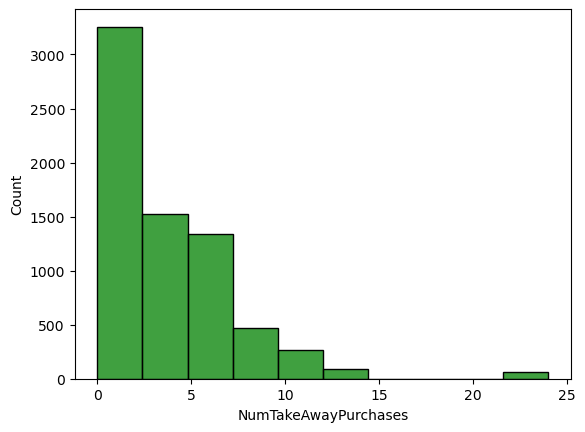

In [28]:
sns.histplot(data = sales, x = 'NumTakeAwayPurchases', color="g", bins = 10)

In [33]:
#percentagem de outliers na variavel NumTakeAwayPurchases
(sum(sales['NumTakeAwayPurchases'] > 20)/7000)*100

0.8714285714285714

In [31]:
sales.shape

(7000, 14)

In [34]:
sales_NO = sales.copy()

In [35]:
sales_NO = sales_NO.drop(sales_NO[sales_NO['NumTakeAwayPurchases'] > 20].index)

## Clusters - Perspectiva preferência pela via de consumo (APP,TK AWAY, STORE)

Identify the right number of clusters

In [425]:
#Criar subset com as variáveis que vão contribuir para os clusters
sales_vc = sales_NO[[ 'NumAppPurchases','NumTakeAwayPurchases', 'NumStorePurchases',]].copy()
sales_vc

NumAppPurchases  NumTakeAwayPurchases  NumStorePurchases
CustomerID                                                          
11054                    13                     4                 13
17117                     9                     7                  9
31751                     9                     5                  3
12947                     7                     5                 11
11402                     4                     1                  3
...                     ...                   ...                ...
23699                     4                     1                  4
23255                     5                     1                  3
5798                      8                     4                 13
16577                     3                     2                  2
25310                     3                     2                  4

[6939 rows x 3 columns]

In [ ]:
##################################################################################################################
#Não vamos fazer normalização (z-score)

In [ ]:
#from sklearn.preprocessing import StandardScaler

## Create an instance of the scaler
#scaler = StandardScaler()

## Fit and transform the data
#scaled_data_standard = scaler.fit_transform(sales_vc)


In [427]:
from sklearn.preprocessing import MinMaxScaler


# Create an instance of the scaler
scaler = MinMaxScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(sales_vc)

In [428]:
# create new dataframe with scaled data
sales_vc_minmax = pd.DataFrame(scaled_data, columns=['NumAppPurchases','NumTakeAwayPurchases', 'NumStorePurchases'])

In [429]:
sales_vc_minmax.head(10)

NumAppPurchases  NumTakeAwayPurchases  NumStorePurchases
0         1.000000              0.333333           1.000000
1         0.692308              0.583333           0.692308
2         0.692308              0.416667           0.230769
3         0.538462              0.416667           0.846154
4         0.307692              0.083333           0.230769
5         0.461538              0.250000           0.230769
6         0.538462              0.750000           0.615385
7         0.538462              0.333333           0.307692
8         0.230769              0.083333           0.230769
9         0.923077              0.166667           0.615385

In [430]:
ks = range(1, 11)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k).fit(sales_vc_minmax)
    inertias.append(model.inertia_)

C:\Users\J Loureiro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\J Loureiro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\J Loureiro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\J Loureiro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\J Loureiro\anaconda3\lib\si

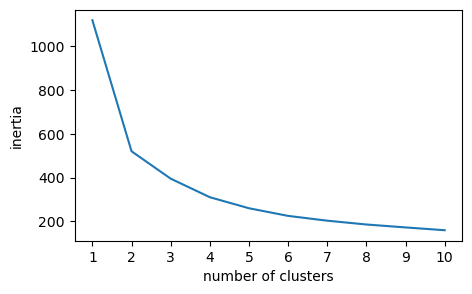

In [431]:
# Plot ks (x-axis) vs inertias (y-axis) using plt.plot(). 
plt.plot(ks, inertias)

# define the label for the x axis as 'number of clusters' using matplotlib.pyplot.xlabel
plt.xlabel('number of clusters')
# define the label for the y axis as 'inertia' using matplotlib.pyplot.ylabel
plt.ylabel('inertia')
# define the ticks on the x axis using the values of ks
plt.xticks(ks)
# call plt.show()
plt.show()

C:\Users\J Loureiro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\J Loureiro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\J Loureiro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\J Loureiro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\J Loureiro\anaconda3\lib\si

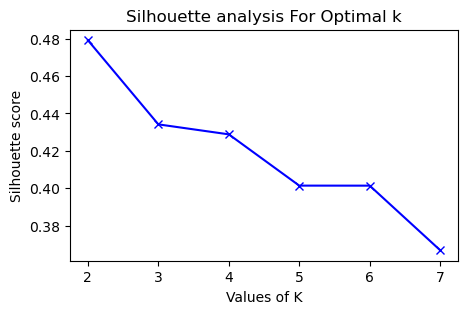

In [432]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

range_n_clusters = [2, 3, 4, 5, 6, 7]
silhouette_avg = []
for num_clusters in range_n_clusters:

    # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(sales_vc_minmax)
    cluster_labels = kmeans.labels_

    # silhouette score
    silhouette_avg.append(silhouette_score(sales_vc_minmax, cluster_labels))

plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

The optimal K with the Silhouette method is 2! 

The silhouette coefficient or silhouette score kmeans is a measure of how similar a data point is within-cluster (cohesion) compared to other clusters (separation). 
https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/

Testar K= 2; 3; 4 

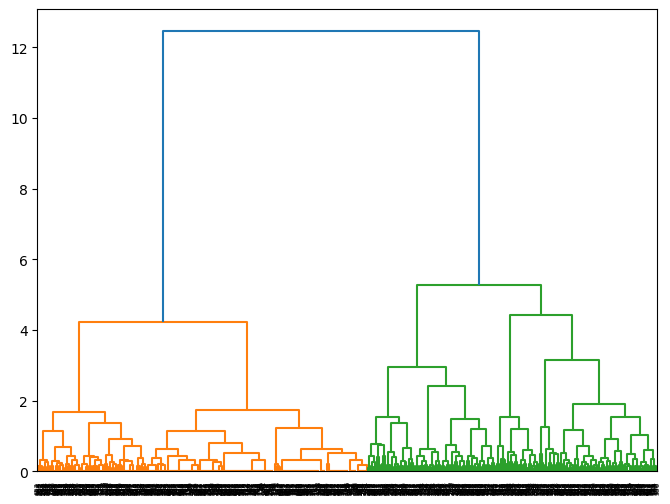

In [433]:
    from scipy.cluster import hierarchy
#from sklearn.cluster import AgglomerativeClustering - The option available in sklearn

# Get a random sample, as hierarchical clustering can take a lot of time to run.
sales_vc_sample = sales_vc_minmax.sample(n = 1000, random_state = 100)

# create clusters using the "ward method"
clusters = hierarchy.linkage(sales_vc_sample , method="ward")

# create the dendrogram using the hierarchy.dendrogram() method.
plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)

## 2 Clusters (K=2)

In [434]:
sales_vc_k2 = sales_vc_minmax.copy()
model_k2 = KMeans(n_clusters=2, random_state = 100).fit(sales_vc_k2)

C:\Users\J Loureiro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [435]:
sales_vc_k2['k_label'] = model_k2.labels_

In [436]:
sales_vc_k2.groupby(['k_label']).mean().transpose()

k_label                      0         1
NumAppPurchases       0.331160  0.609301
NumTakeAwayPurchases  0.139817  0.480055
NumStorePurchases     0.259267  0.649380

In [437]:
sales_vc_k2.groupby(['k_label']).describe().transpose()

k_label                               0            1
NumAppPurchases      count  3563.000000  3376.000000
                     mean      0.331160     0.609301
                     std       0.126555     0.180388
                     min       0.000000     0.230769
                     25%       0.230769     0.461538
                     50%       0.307692     0.615385
                     75%       0.384615     0.769231
                     max       0.846154     1.000000
NumTakeAwayPurchases count  3563.000000  3376.000000
                     mean      0.139817     0.480055
                     std       0.077290     0.215570
                     min       0.000000     0.166667
                     25%       0.083333     0.333333
                     50%       0.083333     0.416667
                     75%       0.166667     0.583333
                     max       0.583333     1.000000
NumStorePurchases    count  3563.000000  3376.000000
                     mean      0.259267     0.649380
                     std       0.098824     0.204103
                     min       0.000000     0.230769
                     25%       0.230769     0.461538
                     50%       0.230769     0.615385
                     75%       0.307692     0.846154
                     max       0.615385     1.000000

## 3 Clusters (K=3) 

In [438]:
sales_vc_k3 = sales_vc_minmax.copy()
model_k3 = KMeans(n_clusters=3, random_state = 100).fit(sales_vc_k3)

C:\Users\J Loureiro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [439]:
sales_vc_k3['k_label'] = model_k3.labels_

In [440]:
sales_vc_k3.groupby(['k_label']).mean().transpose()

k_label                      0         1         2
NumAppPurchases       0.313308  0.532468  0.657535
NumTakeAwayPurchases  0.134917  0.675587  0.313974
NumStorePurchases     0.247175  0.671722  0.607649

Ordem de grandeza do clusters (n.º de individuos) : 2 < 0 < 1 

- C0 compra mais na app e na loja (grupo de clientes regulares)
- C1 é o que tem mais gentes mas o que consome menos (clientes não regulares)
- C2 compra mais no TK Away, mas o cluster que consome mais no geral (grupo de clientes regulares que previligiam o TK Away)


In [441]:
descr = sales_vc_k3.groupby(['k_label']).describe().transpose()
descr

k_label                               0            1            2
NumAppPurchases      count  3315.000000  1476.000000  2148.000000
                     mean      0.313308     0.532468     0.657535
                     std       0.108212     0.153899     0.173497
                     min       0.000000     0.230769     0.230769
                     25%       0.230769     0.384615     0.538462
                     50%       0.307692     0.538462     0.615385
                     75%       0.384615     0.615385     0.769231
                     max       0.692308     1.000000     1.000000
NumTakeAwayPurchases count  3315.000000  1476.000000  2148.000000
                     mean      0.134917     0.675587     0.313974
                     std       0.077250     0.158487     0.103924
                     min       0.000000     0.333333     0.083333
                     25%       0.083333     0.583333     0.250000
                     50%       0.083333     0.666667     0.333333
                     75%       0.166667     0.750000     0.416667
                     max       0.583333     1.000000     0.666667
NumStorePurchases    count  3315.000000  1476.000000  2148.000000
                     mean      0.247175     0.671722     0.607649
                     std       0.087665     0.219730     0.193276
                     min       0.000000     0.230769     0.153846
                     25%       0.230769     0.461538     0.461538
                     50%       0.230769     0.692308     0.615385
                     75%       0.307692     0.846154     0.769231
                     max       0.615385     1.000000     1.000000

## 4 Clusters (K=4) --> SOLUÇÃO

In [442]:
sales_vc_k4 = sales_vc_minmax.copy()
model_k4 = KMeans(n_clusters=4, random_state = 100).fit(sales_vc_k4)

C:\Users\J Loureiro\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [443]:
sales_vc_k4['k_label'] = model_k4.labels_

In [444]:
sales_vc_k4.groupby(['k_label']).mean().transpose()

k_label                      0         1         2         3
NumAppPurchases       0.540593  0.293725  0.621692  0.598524
NumTakeAwayPurchases  0.722864  0.122646  0.281059  0.470787
NumStorePurchases     0.496802  0.233330  0.480946  0.851036

Ordem de grandeza do clusters (n.º de individuos) : 3 < 2 < 1 < 0

- C0 (geral_avg~8)  APP e Loja está mais equilibrado e que menos consome TK Away; é o grupo que tem mais individuos (Menos regulares)
- C1 (geral_avg~19) Consome mais na APP
- C2 (geral_avg~24) consome mais na loja, é o que consome mais na loja, são clientes regulares
- C3 (geral_avg=24) consome maioritariamente TK Away (praticamente só Tk Away e nada na app e loja) grupo de clientes regulares que previligiam o TK Away, "habituais"); A mediana é =0 para a compra na APP e na Loja


In [445]:
sales_vc_k4.groupby(['k_label']).describe().transpose()

k_label                              0            1            2            3
NumAppPurchases      count  866.000000  2974.000000  1744.000000  1355.000000
                     mean     0.540593     0.293725     0.621692     0.598524
                     std      0.155951     0.092101     0.169122     0.183748
                     min      0.230769     0.000000     0.230769     0.230769
                     25%      0.461538     0.230769     0.461538     0.461538
                     50%      0.538462     0.307692     0.615385     0.538462
                     75%      0.615385     0.384615     0.769231     0.692308
                     max      1.000000     0.538462     1.000000     1.000000
NumTakeAwayPurchases count  866.000000  2974.000000  1744.000000  1355.000000
                     mean     0.722864     0.122646     0.281059     0.470787
                     std      0.154523     0.062403     0.100195     0.173401
                     min      0.500000     0.000000     0.083333     0.250000
                     25%      0.583333     0.083333     0.166667     0.333333
                     50%      0.666667     0.083333     0.250000     0.416667
                     75%      0.833333     0.166667     0.333333     0.583333
                     max      1.000000     0.500000     0.583333     1.000000
NumStorePurchases    count  866.000000  2974.000000  1744.000000  1355.000000
                     mean     0.496802     0.233330     0.480946     0.851036
                     std      0.154932     0.076361     0.121340     0.102892
                     min      0.230769     0.000000     0.153846     0.615385
                     25%      0.384615     0.230769     0.384615     0.769231
                     50%      0.461538     0.230769     0.461538     0.846154
                     75%      0.615385     0.307692     0.615385     0.923077
                     max      0.923077     0.615385     0.692308     1.000000

## Visualização

HISTOGRAMAS

In [446]:
cluster0 = sales_vc_k4[sales_vc_k4.k_label==0]
cluster1 = sales_vc_k4[sales_vc_k4.k_label==1]
cluster2 = sales_vc_k4[sales_vc_k4.k_label==2]
cluster3 = sales_vc_k4[sales_vc_k4.k_label==3]

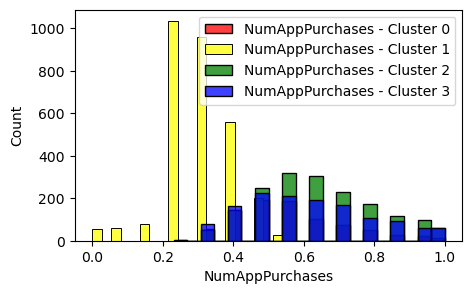

In [447]:
sns.histplot(cluster0['NumAppPurchases'],color='red',label='NumAppPurchases - Cluster 0', bins = 20)
sns.histplot(cluster1['NumAppPurchases'],color='yellow',label='NumAppPurchases - Cluster 1', bins = 20)
sns.histplot(cluster2['NumAppPurchases'],color='green',label='NumAppPurchases - Cluster 2', bins = 20)
sns.histplot(cluster3['NumAppPurchases'],color='blue',label='NumAppPurchases - Cluster 3', bins = 20)
plt.legend()

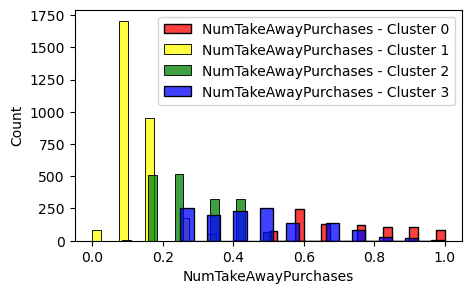

In [448]:
sns.histplot(cluster0['NumTakeAwayPurchases'],color='red',label='NumTakeAwayPurchases - Cluster 0', bins = 20)
sns.histplot(cluster1['NumTakeAwayPurchases'],color='yellow',label='NumTakeAwayPurchases - Cluster 1', bins = 20)
sns.histplot(cluster2['NumTakeAwayPurchases'],color='green',label='NumTakeAwayPurchases - Cluster 2', bins = 20)
sns.histplot(cluster3['NumTakeAwayPurchases'],color='blue',label='NumTakeAwayPurchases - Cluster 3', bins = 20)
plt.legend()

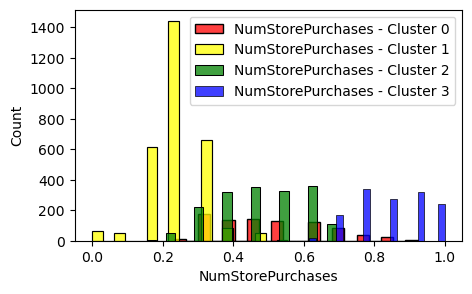

In [449]:
sns.histplot(cluster0['NumStorePurchases'],color='red',label='NumStorePurchases - Cluster 0', bins = 20)
sns.histplot(cluster1['NumStorePurchases'],color='yellow',label='NumStorePurchases - Cluster 1', bins = 20)
sns.histplot(cluster2['NumStorePurchases'],color='green',label='NumStorePurchases - Cluster 2', bins = 20)
sns.histplot(cluster3['NumStorePurchases'],color='blue',label='NumStorePurchases - Cluster 3', bins = 20)
plt.legend()

SCATTER PLOT

In [450]:
centroids = model_k4.cluster_centers_
centroids

array([[0.54059336, 0.72286374, 0.49680227],
       [0.2937251 , 0.12264627, 0.23332988],
       [0.62117595, 0.28055556, 0.4806366 ],
       [0.59925284, 0.47087319, 0.85034245]])

In [451]:
sales_vc_minmax.columns

Index(['NumAppPurchases', 'NumTakeAwayPurchases', 'NumStorePurchases'], dtype='object')

In [452]:
centroid_0_APP = centroids[0,0]
centroid_1_APP = centroids[1,0]
centroid_2_APP = centroids[2,0]
centroid_3_APP = centroids[3,0]
centroid_0_STORE = centroids[0,1]
centroid_1_STORE = centroids[1,1]
centroid_2_STORE = centroids[2,1]
centroid_3_STORE = centroids[3,1]
centroid_0_TKAWAY = centroids[0,2]
centroid_1_TKAWAY = centroids[1,2]
centroid_2_TKAWAY = centroids[2,2]
centroid_3_TKAWAY = centroids[3,2]

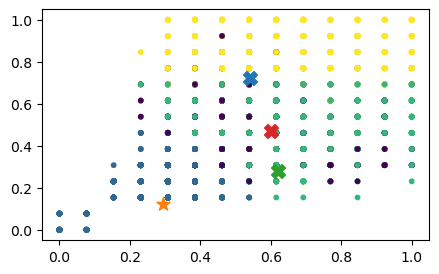

In [453]:
plt.scatter(sales_vc_k4.NumAppPurchases, sales_vc_k4.NumStorePurchases,
            c=sales_vc_k4.k_label, s=10)

plt.scatter(centroid_0_APP, centroid_0_STORE, marker='X', s=100)#AZUL
plt.scatter(centroid_1_APP, centroid_1_STORE, marker='*', s=100)#LARANJA
plt.scatter(centroid_2_APP, centroid_2_STORE, marker='X', s=100)#VERDE
plt.scatter(centroid_3_APP, centroid_3_STORE, marker='X', s=100)#VERMELHO

plt.show()

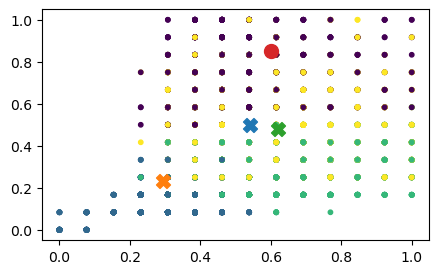

In [454]:
plt.scatter(sales_vc_k4.NumAppPurchases, sales_vc_k4.NumTakeAwayPurchases,
            c=sales_vc_k4.k_label, s=10)

plt.scatter(centroid_0_APP, centroid_0_TKAWAY, marker='X', s=100)
plt.scatter(centroid_1_APP, centroid_1_TKAWAY, marker='X', s=100)
plt.scatter(centroid_2_APP, centroid_2_TKAWAY, marker='X', s=100)
plt.scatter(centroid_3_APP, centroid_3_TKAWAY, marker='o', s=100)

plt.show()

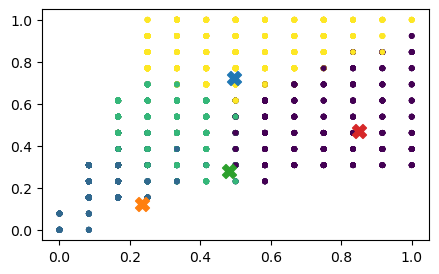

In [455]:
plt.scatter(sales_vc_k4.NumTakeAwayPurchases, sales_vc_k4.NumStorePurchases,
            c=sales_vc_k4.k_label, s=10)

plt.scatter(centroid_0_TKAWAY, centroid_0_STORE, marker='X', s=100)
plt.scatter(centroid_1_TKAWAY, centroid_1_STORE, marker='X', s=100)
plt.scatter(centroid_2_TKAWAY, centroid_2_STORE, marker='X', s=100)
plt.scatter(centroid_3_TKAWAY, centroid_3_STORE, marker='X', s=100)

plt.show()

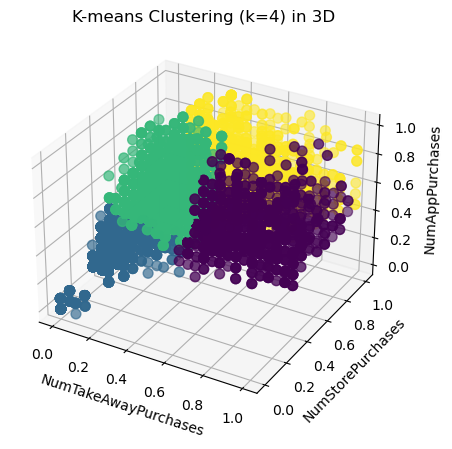

In [456]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(5, 9))
ax = fig.add_subplot(111, projection='3d')

x = sales_vc_k4.NumTakeAwayPurchases
y = sales_vc_k4.NumStorePurchases
z = sales_vc_k4.NumAppPurchases
c = sales_vc_k4.k_label

ax.scatter(x, y, z, c=c, s=50)

ax.set_xlabel('NumTakeAwayPurchases')
ax.set_ylabel('NumStorePurchases')
ax.set_zlabel('NumAppPurchases')

plt.title("K-means Clustering (k=4) in 3D")
plt.show()


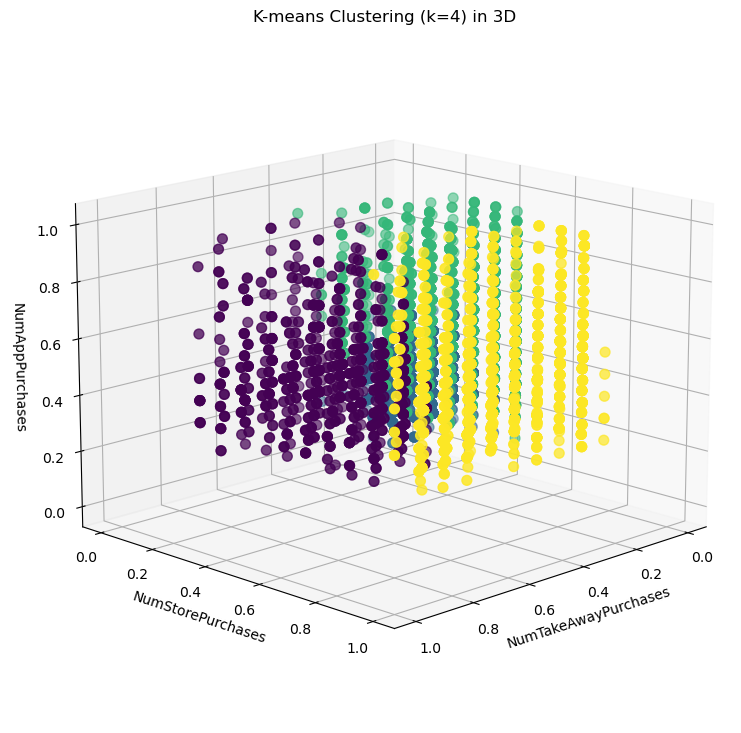

In [457]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

x = sales_vc_k4.NumTakeAwayPurchases
y = sales_vc_k4.NumStorePurchases
z = sales_vc_k4.NumAppPurchases
c = sales_vc_k4.k_label

ax.scatter(x, y, z, c=c, s=50)

ax.set_xlabel('NumTakeAwayPurchases')
ax.set_ylabel('NumStorePurchases')
ax.set_zlabel('NumAppPurchases')

# Change the angle
ax.view_init(elev=15, azim=45)

plt.title("K-means Clustering (k=4) in 3D")
plt.show()


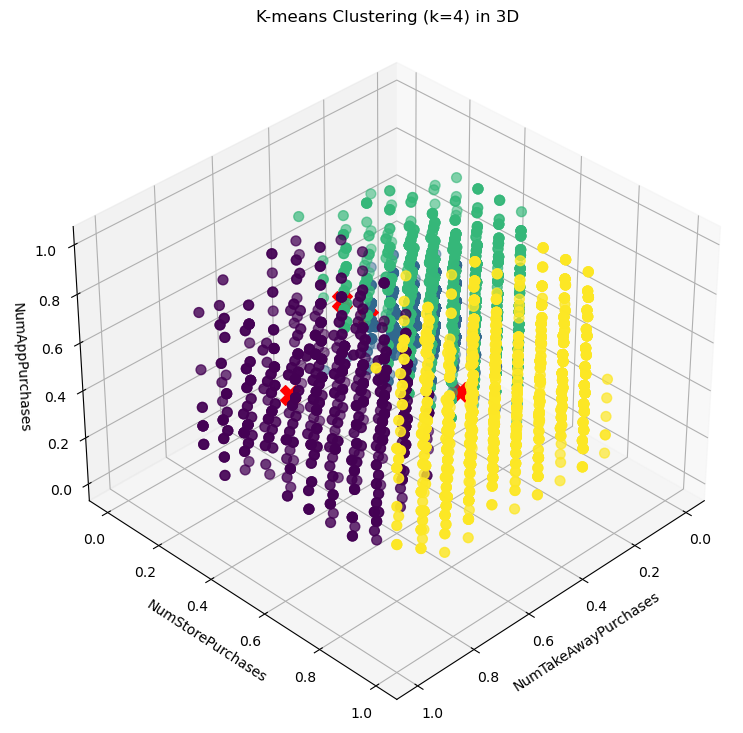

In [458]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

x = sales_vc_k4.NumTakeAwayPurchases
y = sales_vc_k4.NumStorePurchases
z = sales_vc_k4.NumAppPurchases
c = sales_vc_k4.k_label

ax.scatter(x, y, z, c=c, s=50)

# Add centroids
ax.scatter(centroid_0_TKAWAY, centroid_0_STORE, centroid_0_APP, marker='X', s=200, c='red')
ax.scatter(centroid_1_TKAWAY, centroid_1_STORE, centroid_1_APP, marker='X', s=200, c='red')
ax.scatter(centroid_2_TKAWAY, centroid_2_STORE, centroid_2_APP, marker='X', s=200, c='red')
ax.scatter(centroid_3_TKAWAY, centroid_3_STORE, centroid_3_APP, marker='X', s=200, c='red')

ax.set_xlabel('NumTakeAwayPurchases')
ax.set_ylabel('NumStorePurchases')
ax.set_zlabel('NumAppPurchases')

# Change the angle
ax.view_init(elev=35, azim=45) #change elevation to check the centroids a bit better

plt.title("K-means Clustering (k=4) in 3D")
plt.show()


In [459]:
#other solutions

<function matplotlib.pyplot.show(close=None, block=None)>

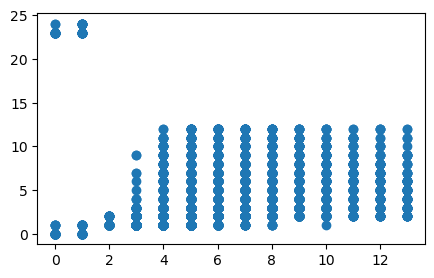

In [460]:
plt.scatter(sales["NumAppPurchases"], sales["NumTakeAwayPurchases"])
plt.show

In [461]:
centroids = model_k2.cluster_centers_
centroids

array([[0.33116   , 0.13981663, 0.25926726],
       [0.60930095, 0.48005529, 0.64938024]])

In [462]:
centroid_0_APP = centroids[0,0]
centroid_1_APP = centroids[1,0]
centroid_0_STORE = centroids[0,1]
centroid_1_STORE = centroids[1,1]
centroid_0_TKAWAY = centroids[0,2]
centroid_1_TKAWAY = centroids[1,2]

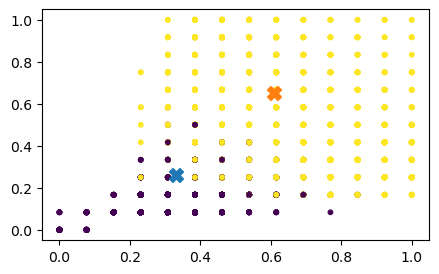

In [463]:
plt.scatter(sales_vc_k2.NumAppPurchases, sales_vc_k2.NumTakeAwayPurchases,
            c=sales_vc_k2.k_label, s=10)

plt.scatter(centroid_0_APP, centroid_0_TKAWAY, marker='X', s=100)
plt.scatter(centroid_1_APP, centroid_1_TKAWAY, marker='X', s=100)

plt.show()

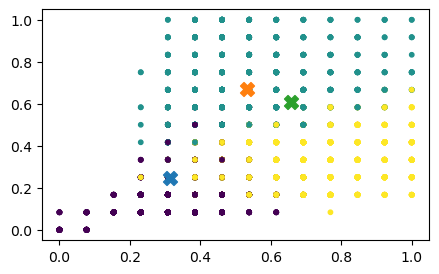

In [464]:
centroids = model_k3.cluster_centers_
centroids

centroid_0_APP = centroids[0,0]
centroid_1_APP = centroids[1,0]
centroid_2_APP = centroids[2,0]
centroid_0_STORE = centroids[0,1]
centroid_1_STORE = centroids[1,1]
centroid_2_STORE = centroids[2,1]
centroid_0_TKAWAY = centroids[0,2]
centroid_1_TKAWAY = centroids[1,2]
centroid_2_TKAWAY = centroids[2,2]



plt.scatter(sales_vc_k3.NumAppPurchases, sales_vc_k3.NumTakeAwayPurchases,
            c=sales_vc_k3.k_label, s=10)

plt.scatter(centroid_0_APP, centroid_0_TKAWAY, marker='X', s=100)
plt.scatter(centroid_1_APP, centroid_1_TKAWAY, marker='X', s=100)
plt.scatter(centroid_2_APP, centroid_2_TKAWAY, marker='X', s=100)

plt.show()

<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### DBSCAN clustering 
    
</div>

Ran the code of this site: https://www.reneshbedre.com/blog/dbscan-python.html?utm_content=cmp-true

In [465]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors = 20).fit(sales_vc_minmax)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(sales_vc_minmax)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis = 0)

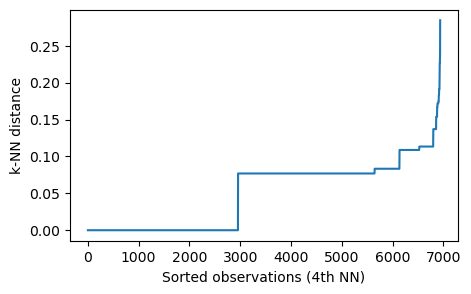

In [466]:
import matplotlib.pyplot as plt
k_dist = sort_neigh_dist[:, 19]
plt.plot(k_dist)
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()


- Identifying the exact knee point could be difficult visually. In the below plot, the knee point can occur at any point between 1 to 2 i.e. the points below knee point belong to a cluster, and points above the knee point are noise or outliers (noise points will have higher kNN distance). You should run DBSCAN based on different values of ε (between 1 and 2) to find the best ε that gives the best clustering.

- Additionally, to get an estimate of knee point, you can use the KneeLocator() function from the kneed package.

In [467]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


In [468]:
from kneed import KneeLocator
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)

# get the estimate of knee point
print(kneedle.knee_y)

0.23950694477268478


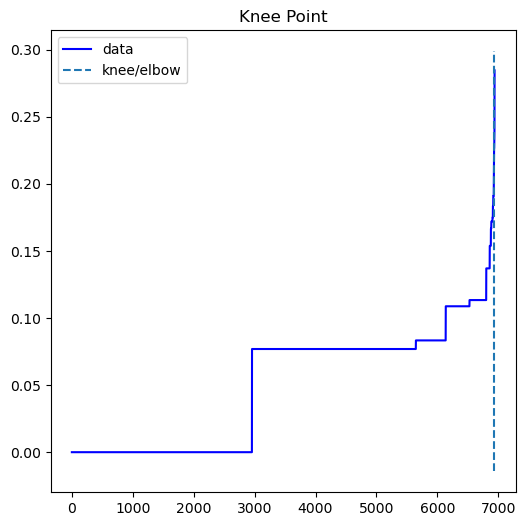

In [469]:
#distance plot
kneedle.plot_knee()
plt.show()

In [470]:
from sklearn.cluster import DBSCAN
clusters = DBSCAN(eps = 1.0714574598551223, min_samples = 2).fit(sales_vc_minmax)

In [471]:
# get cluster labels
clusters.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [472]:
# check unique clusters
set(clusters.labels_)

{0}

In [473]:
from collections import Counter
Counter(clusters.labels_)

Counter({0: 6939})

Visualization of DBSCAN clustering

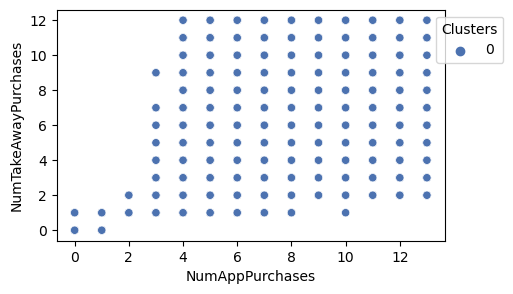

In [474]:
import seaborn as sns
import matplotlib.pyplot as plt
p = sns.scatterplot(data = sales_vc, x = "NumAppPurchases", y = "NumTakeAwayPurchases", hue = clusters.labels_, legend = "full", palette = "deep")
sns.move_legend(p, "upper right", bbox_to_anchor = (1.17, 1.), title = 'Clusters')
plt.show()

## ran the code of this site: https://www.section.io/engineering-education/dbscan-clustering-in-python/

In [475]:
from sklearn.neighbors import NearestNeighbors # importing the library
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(sales_vc) # fitting the data to the object
distances,indices=nbrs.kneighbors(sales_vc) # finding the nearest neighbours

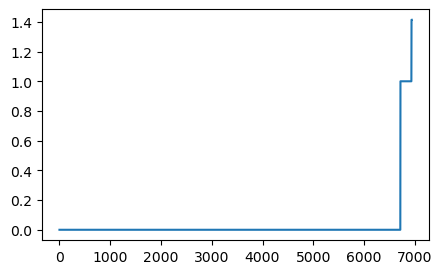

In [476]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot


<div class="alert alert-block alert-info">
    
<a id='stats_num'></a>

### Fuzzy clustering/c-means
    
    #https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html
#(source) FPC method for finding whether a fuzzyness value, m, is optimal
    
</div>

In [477]:
!pip install scikit-fuzzy

In [478]:
#Find the level of fuzzinness m, for k=3, using Fuzzy Partition Coefficient, trying multiple values for error

import numpy as np
import skfuzzy as fuzz
from sklearn.datasets import make_blobs

for error in np.arange(0.1, 5.1, 0.1):
    data=sales_vc_minmax.copy()
    # Perform fuzzy clustering with optimal number of clusters
    cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(data.T, 3, 2, error, maxiter=10000, init=None)

    # Find the optimal fuzziness
    optimal_fuzziness = np.argmax(fpc)
    print("Optimal fuzziness:", optimal_fuzziness)


Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzzi

In [479]:
#Find the level of fuzzinness m, for k=4, using Fuzzy Partition Coefficient, trying multiple values for error
#FPC is between 0 and 1, the closer it is to 0, the less the model os effective in partitioning our data

import numpy as np
import skfuzzy as fuzz

for error in np.arange(0.1, 3.1, 0.1):
    for m in np.arange(1, 5, 1):
        data=sales_vc_minmax.copy()
        # Perform fuzzy clustering with optimal number of clusters
        cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(data.T, 4, m, error, maxiter=150, init=None)

        # Find the optimal fuzziness
        optimal_fuzziness = np.argmax(fpc)
        print("Optimal fuzziness:", optimal_fuzziness)

Optimal fuzziness: 0


C:\Users\J Loureiro\anaconda3\lib\site-packages\skfuzzy\cluster\_cmeans.py:33: RuntimeWarning: divide by zero encountered in true_divide
  u = normalize_power_columns(d, - 2. / (m - 1))


Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzziness: 0
Optimal fuzzi

In [480]:
#from the values we got on the FPC, it's clear that fuzzy clustering is not at all appropriate to analyze our data set

In [481]:
import numpy as np
import skfuzzy as fuzz

fuzzy=sales_vc_minmax.copy()

# Set the number of clusters
k = 4

# Set the fuzziness parameter
m = 2

# Initialize the cluster centers
centers, u, _, _, _, _, _ = fuzz.cluster.cmeans(fuzzy.T, k, m, error=0.005, maxiter=1000, init=None)

# Get the cluster labels for each data point
labels = np.argmax(u, axis=0)

# Print the cluster centers and labels
print("Cluster centers:")
print(centers)
print("Cluster labels:")
print(labels)

Cluster centers:
[[0.28829621 0.11827409 0.23150148]
 [0.60295426 0.4318744  0.81036183]
 [0.60420504 0.28027655 0.45990212]
 [0.54904221 0.66730734 0.58214746]]
Cluster labels:
[1 3 2 ... 1 0 0]


In [482]:
#Further testing---- vizualization of innefectiveness for m (fuzzynness)=2

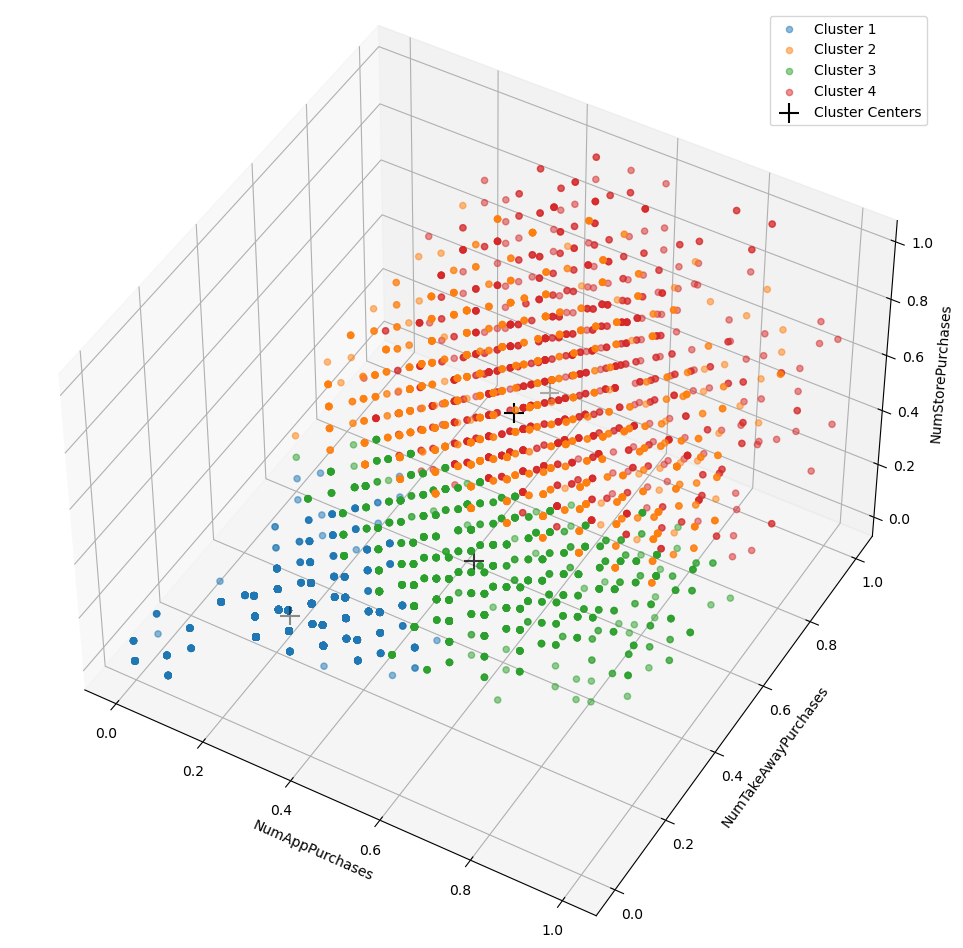

In [483]:
# Create a 3D plot
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points colored by cluster label
for i in range(k):
    ax.scatter(sales_vc_minmax.iloc[labels==i, 0], sales_vc_minmax.iloc[labels==i, 1], sales_vc_minmax.iloc[labels==i, 2], alpha=0.5, label="Cluster "+str(i+1))

# Plot the cluster centers
ax.scatter(centers[:,0], centers[:,1], centers[:,2], color='black', marker='+', s=200, label="Cluster Centers")

# Add legend and axis labels
ax.set_xlabel('NumAppPurchases')
ax.set_ylabel('NumTakeAwayPurchases')
ax.set_zlabel('NumStorePurchases')
ax.legend()

# Set the viewing angle
ax.view_init(elev=45, azim=-60)

# Show the plot
plt.show()


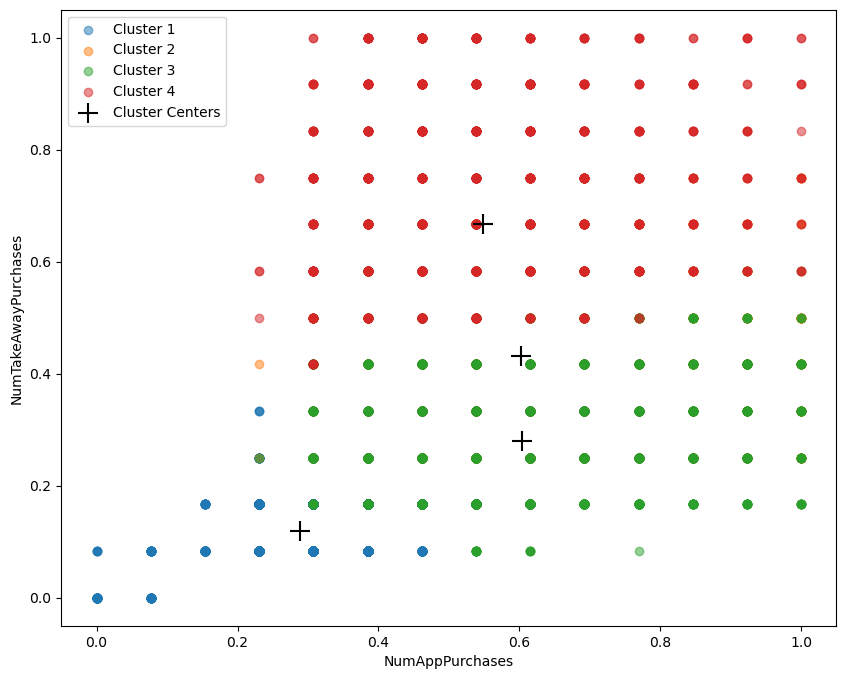

In [484]:
# Create a 2D plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data points colored by cluster label
for i in range(k):
    ax.scatter(sales_vc_minmax.iloc[labels==i, 0], sales_vc_minmax.iloc[labels==i, 1], alpha=0.5, label="Cluster "+str(i+1))

# Plot the cluster centers
ax.scatter(centers[:,0], centers[:,1], color='black', marker='+', s=200, label="Cluster Centers")

# Add legend and axis labels
ax.set_xlabel('NumAppPurchases')
ax.set_ylabel('NumTakeAwayPurchases')
ax.legend()

# Show the plot
plt.show()


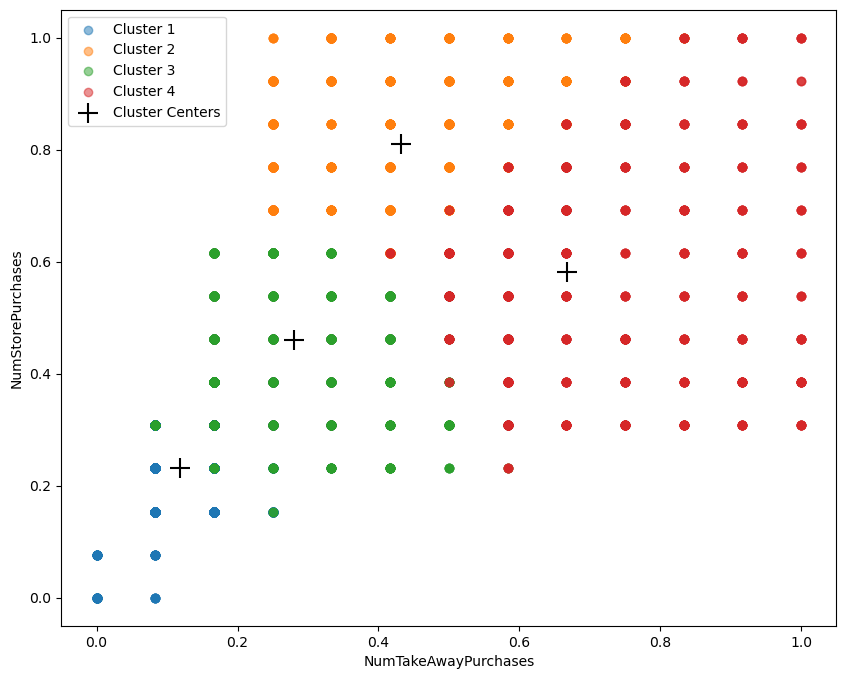

In [485]:
# Create a 2D plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data points colored by cluster label
for i in range(k):
    ax.scatter(sales_vc_minmax.iloc[labels==i, 1], sales_vc_minmax.iloc[labels==i, 2], alpha=0.5, label="Cluster "+str(i+1))

# Plot the cluster centers
ax.scatter(centers[:,1], centers[:,2], color='black', marker='+', s=200, label="Cluster Centers")

# Add legend and axis labels
ax.set_xlabel('NumTakeAwayPurchases')
ax.set_ylabel('NumStorePurchases')
ax.legend()

# Show the plot
plt.show()


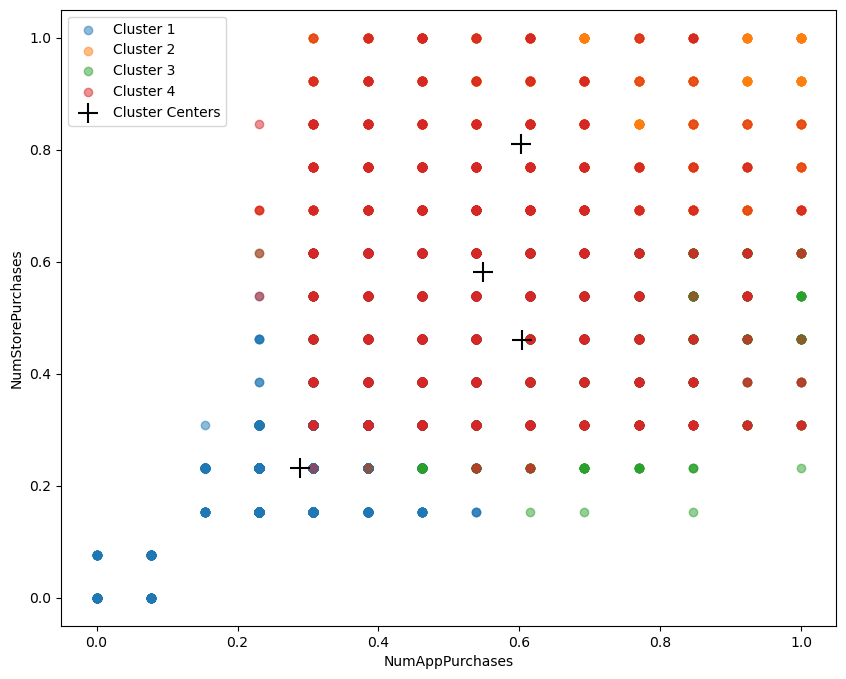

In [486]:
# Create a 2D plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data points colored by cluster label
for i in range(k):
    ax.scatter(sales_vc_minmax.iloc[labels==i, 0], sales_vc_minmax.iloc[labels==i, 2], alpha=0.5, label="Cluster "+str(i+1))

# Plot the cluster centers
ax.scatter(centers[:,0], centers[:,2], color='black', marker='+', s=200, label="Cluster Centers")

# Add legend and axis labels
ax.set_xlabel('NumAppPurchases')
ax.set_ylabel('NumStorePurchases')
ax.legend()

# Show the plot
plt.show()


In [487]:
#and for m=4...

In [488]:
import numpy as np
import skfuzzy as fuzz

fuzzy=sales_vc_minmax.copy()

# Set the number of clusters
k = 4

# Set the fuzziness parameter
m = 4

# Initialize the cluster centers
centers, u, _, _, _, _, _ = fuzz.cluster.cmeans(fuzzy.T, k, m, error=0.005, maxiter=1000, init=None)

# Get the cluster labels for each data point
labels = np.argmax(u, axis=0)

# Print the cluster centers and labels
print("Cluster centers:")
print(centers)
print("Cluster labels:")
print(labels)

Cluster centers:
[[0.58694238 0.44570925 0.62267195]
 [0.28165955 0.10793655 0.23101412]
 [0.58172724 0.49845931 0.690276  ]
 [0.52736987 0.29298432 0.44094249]]
Cluster labels:
[2 2 3 ... 2 1 1]


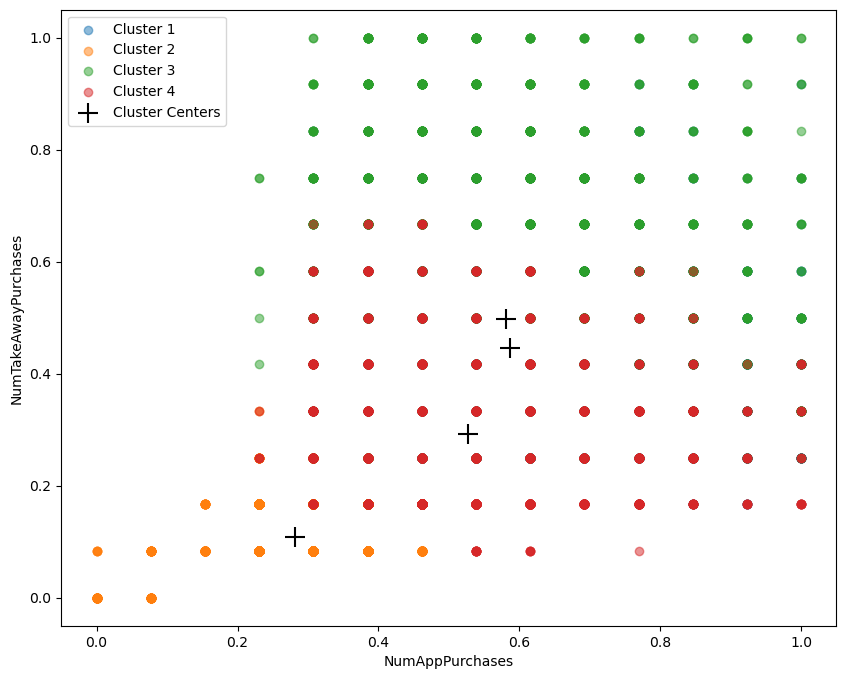

In [489]:
# Create a 2D plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data points colored by cluster label
for i in range(k):
    ax.scatter(sales_vc_minmax.iloc[labels==i, 0], sales_vc_minmax.iloc[labels==i, 1], alpha=0.5, label="Cluster "+str(i+1))

# Plot the cluster centers
ax.scatter(centers[:,0], centers[:,1], color='black', marker='+', s=200, label="Cluster Centers")

# Add legend and axis labels
ax.set_xlabel('NumAppPurchases')
ax.set_ylabel('NumTakeAwayPurchases')
ax.legend()

# Show the plot
plt.show()

In [490]:
#https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html
#source for FPC method for finding whether a fuzzyness m is optimal

In [491]:
#fuzzy clustering doesn't seem appropriate...

In [494]:
#BACK TO REGULAR KMEANS; K=4

In [495]:
cluster0 = sales_vc_k4[sales_vc_k4.k_label==0]
cluster1 = sales_vc_k4[sales_vc_k4.k_label==1]
cluster2 = sales_vc_k4[sales_vc_k4.k_label==2]
cluster3 = sales_vc_k4[sales_vc_k4.k_label==3]

In [496]:
crm=pd.read_csv(r'C:\Users\J Loureiro\Desktop\Enterprise Data Science and Advanced Analytics\Data Science and Machine Learning\Project 1\crm.csv')

In [497]:
crm

CustomerID                  Name  Birthyear   Education Marital_Status  \
0          14594       Miss Leah Lewis       1981  Graduation         Single   
1          19070      Miss Grace Black       1974  Graduation       Together   
2          29888    Mr. Gavin Morrison       1960         PhD       Together   
3          12221       Mr. Ryan Glover       1980  Graduation        Married   
4          21107     Mr. Paul Anderson       1971  HighSchool         Single   
...          ...                   ...        ...         ...            ...   
6995       30686       Mr. John Hughes       1994         PhD       Divorced   
6996       17210   Mr. Brandon Simpson       1985  Graduation       Divorced   
6997       29186  Mr. Thomas Churchill       1967         PhD       Together   
6998       23312    Miss Angela Murray       1989  Graduation         Single   
6999       15581     Miss Diana Taylor       1960  Graduation         Single   

        Income  Kid_Younger6  Children_6to18  
0     113947.0             0               0  
1     114297.0             0               0  
2     115476.0             0               0  
3     101172.0             1               1  
4     123128.0             0               0  
...        ...           ...             ...  
6995   98968.0             0               0  
6996  109977.0             0               0  
6997   56039.0             0               1  
6998   44867.0             1               0  
6999  124379.0             0               0  

[7000 rows x 8 columns]

In [498]:
crm['Education'] = crm['Education'].str.upper()

In [499]:
crm['Marital_Status']=crm['Marital_Status'].str.upper()

In [500]:
#3.1 birthyear into age


#first, we convert the birthyear to an 'age' column

import datetime
    
 #calculate the current year
current_year = datetime.datetime.now().year

 #create a new column 'age' by subtracting birth_year from current year
crm['age'] = current_year - crm['Birthyear']

# drop
crm = crm.drop('Birthyear', axis=1)

In [501]:
#Now, we do the encoding. If the first 4 characters contain any variation of mrs or miss, we substitute the name by 1
#if it's any variation of 'mr.' we substitute by 0

# create a copy of the 'Name' column
crm['Gender'] = crm['Name']

# replace 'Miss' or 'Mrs.' with 1 and 'Mr.' with 0 in the 'Gender' column
crm.loc[crm['Gender'].str.contains(r'^((M|m)iss|(M|m)rs\.)', na=False), 'Gender'] = 1
crm.loc[crm['Gender'].str.contains(r'^(Mr\.|(M|m)r)', na=False), 'Gender'] = 0

# convert the 'Gender' column to integer type
crm['Gender'] = crm['Gender'].astype(float).fillna(0).astype(int)

#check new column
crm['Gender']

C:\Users\J Loureiro\AppData\Local\Temp\ipykernel_27352\298880669.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  crm.loc[crm['Gender'].str.contains(r'^((M|m)iss|(M|m)rs\.)', na=False), 'Gender'] = 1
C:\Users\J Loureiro\AppData\Local\Temp\ipykernel_27352\298880669.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  crm.loc[crm['Gender'].str.contains(r'^(Mr\.|(M|m)r)', na=False), 'Gender'] = 0


0       1
1       1
2       0
3       0
4       0
       ..
6995    0
6996    0
6997    0
6998    1
6999    1
Name: Gender, Length: 7000, dtype: int32

In [502]:
crm

CustomerID                  Name   Education Marital_Status    Income  \
0          14594       Miss Leah Lewis  GRADUATION         SINGLE  113947.0   
1          19070      Miss Grace Black  GRADUATION       TOGETHER  114297.0   
2          29888    Mr. Gavin Morrison         PHD       TOGETHER  115476.0   
3          12221       Mr. Ryan Glover  GRADUATION        MARRIED  101172.0   
4          21107     Mr. Paul Anderson  HIGHSCHOOL         SINGLE  123128.0   
...          ...                   ...         ...            ...       ...   
6995       30686       Mr. John Hughes         PHD       DIVORCED   98968.0   
6996       17210   Mr. Brandon Simpson  GRADUATION       DIVORCED  109977.0   
6997       29186  Mr. Thomas Churchill         PHD       TOGETHER   56039.0   
6998       23312    Miss Angela Murray  GRADUATION         SINGLE   44867.0   
6999       15581     Miss Diana Taylor  GRADUATION         SINGLE  124379.0   

      Kid_Younger6  Children_6to18  age  Gender  
0                0               0   42       1  
1                0               0   49       1  
2                0               0   63       0  
3                1               1   43       0  
4                0               0   52       0  
...            ...             ...  ...     ...  
6995             0               0   29       0  
6996             0               0   38       0  
6997             0               1   56       0  
6998             1               0   34       1  
6999             0               0   63       1  

[7000 rows x 9 columns]

In [503]:
crm_view=crm.copy()

In [504]:
cluster0 = sales_vc_k4[sales_vc_k4.k_label==0]
cluster1 = sales_vc_k4[sales_vc_k4.k_label==1]
cluster2 = sales_vc_k4[sales_vc_k4.k_label==2]
cluster3 = sales_vc_k4[sales_vc_k4.k_label==3]

In [505]:
#DEMOGRAPHICS COMPARISONS!!!!!


conclusions0 = pd.concat([cluster0.reset_index(drop=True), crm_view.reset_index(drop=True)], axis=1, join='inner')
conclusions1 = pd.concat([cluster1.reset_index(drop=True), crm_view.reset_index(drop=True)], axis=1, join='inner')
conclusions2 = pd.concat([cluster2.reset_index(drop=True), crm_view.reset_index(drop=True)], axis=1, join='inner')
conclusions3 = pd.concat([cluster3.reset_index(drop=True), crm_view.reset_index(drop=True)], axis=1, join='inner')

In [506]:
conclusions0.head(2)

NumAppPurchases  NumTakeAwayPurchases  NumStorePurchases  k_label  \
0         0.538462              0.750000           0.615385        0   
1         0.384615              0.666667           0.615385        0   

   CustomerID              Name   Education Marital_Status    Income  \
0       14594   Miss Leah Lewis  GRADUATION         SINGLE  113947.0   
1       19070  Miss Grace Black  GRADUATION       TOGETHER  114297.0   

   Kid_Younger6  Children_6to18  age  Gender  
0             0               0   42       1  
1             0               0   49       1

In [507]:
conclusions0.describe()

NumAppPurchases  NumTakeAwayPurchases  NumStorePurchases  k_label  \
count       866.000000            866.000000         866.000000    866.0   
mean          0.540593              0.722864           0.496802      0.0   
std           0.155951              0.154523           0.154932      0.0   
min           0.230769              0.500000           0.230769      0.0   
25%           0.461538              0.583333           0.384615      0.0   
50%           0.538462              0.666667           0.461538      0.0   
75%           0.615385              0.833333           0.615385      0.0   
max           1.000000              1.000000           0.923077      0.0   

         CustomerID         Income  Kid_Younger6  Children_6to18         age  \
count    866.000000     866.000000    866.000000      866.000000  866.000000   
mean   20466.794457   79836.634873      0.445727        0.472286   46.939954   
std     8866.347950   35535.600632      0.552398        0.541711   12.059433   
min     5078.000000    4609.600000      0.000000        0.000000   18.000000   
25%    12434.750000   53514.750000      0.000000        0.000000   38.000000   
50%    20801.000000   79477.500000      0.000000        0.000000   46.000000   
75%    28180.250000  103483.000000      1.000000        1.000000   56.000000   
max    35072.000000  237639.725000      2.000000        2.000000   74.000000   

           Gender  
count  866.000000  
mean     0.263279  
std      0.440667  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      1.000000

In [508]:
conclusions1.describe()

NumAppPurchases  NumTakeAwayPurchases  NumStorePurchases  k_label  \
count      2974.000000           2974.000000        2974.000000   2974.0   
mean          0.293725              0.122646           0.233330      1.0   
std           0.092101              0.062403           0.076361      0.0   
min           0.000000              0.000000           0.000000      1.0   
25%           0.230769              0.083333           0.230769      1.0   
50%           0.307692              0.083333           0.230769      1.0   
75%           0.384615              0.166667           0.307692      1.0   
max           0.538462              0.500000           0.615385      1.0   

         CustomerID         Income  Kid_Younger6  Children_6to18          age  \
count   2974.000000    2974.000000   2974.000000     2974.000000  2974.000000   
mean   20080.887021   78328.700731      0.441157        0.483188    46.465703   
std     8699.409307   35493.753205      0.541951        0.543642    11.987212   
min     5078.000000    3005.400000      0.000000        0.000000    18.000000   
25%    12470.000000   51289.750000      0.000000        0.000000    37.000000   
50%    20238.500000   77533.500000      0.000000        0.000000    46.000000   
75%    27664.250000  102446.500000      1.000000        1.000000    56.000000   
max    35072.000000  237639.725000      2.000000        2.000000    75.000000   

            Gender  
count  2974.000000  
mean      0.267653  
std       0.442810  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [509]:
conclusions2.describe()

NumAppPurchases  NumTakeAwayPurchases  NumStorePurchases  k_label  \
count      1744.000000           1744.000000        1744.000000   1744.0   
mean          0.621692              0.281059           0.480946      2.0   
std           0.169122              0.100195           0.121340      0.0   
min           0.230769              0.083333           0.153846      2.0   
25%           0.461538              0.166667           0.384615      2.0   
50%           0.615385              0.250000           0.461538      2.0   
75%           0.769231              0.333333           0.615385      2.0   
max           1.000000              0.583333           0.692308      2.0   

         CustomerID         Income  Kid_Younger6  Children_6to18          age  \
count   1744.000000    1744.000000   1744.000000     1744.000000  1744.000000   
mean   20187.503440   78173.096287      0.448394        0.483945    46.399083   
std     8813.027223   34988.851228      0.547961        0.540686    12.012525   
min     5078.000000    3005.400000      0.000000        0.000000    18.000000   
25%    12344.000000   50769.000000      0.000000        0.000000    37.000000   
50%    20369.000000   77771.500000      0.000000        0.000000    45.000000   
75%    27937.250000  102572.000000      1.000000        1.000000    56.000000   
max    35072.000000  237639.725000      2.000000        2.000000    74.000000   

            Gender  
count  1744.000000  
mean      0.268922  
std       0.443527  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [510]:
conclusions3.describe()

NumAppPurchases  NumTakeAwayPurchases  NumStorePurchases  k_label  \
count      1355.000000           1355.000000        1355.000000   1355.0   
mean          0.598524              0.470787           0.851036      3.0   
std           0.183748              0.173401           0.102892      0.0   
min           0.230769              0.250000           0.615385      3.0   
25%           0.461538              0.333333           0.769231      3.0   
50%           0.538462              0.416667           0.846154      3.0   
75%           0.692308              0.583333           0.923077      3.0   
max           1.000000              1.000000           1.000000      3.0   

         CustomerID         Income  Kid_Younger6  Children_6to18          age  \
count   1355.000000    1355.000000   1355.000000     1355.000000  1355.000000   
mean   20313.498893   78342.207823      0.447232        0.469373    46.509225   
std     8870.743903   34894.202266      0.548246        0.534952    12.066979   
min     5078.000000    3005.400000      0.000000        0.000000    18.000000   
25%    12446.000000   51193.500000      0.000000        0.000000    37.000000   
50%    20450.000000   77798.000000      0.000000        0.000000    46.000000   
75%    28304.000000  102853.500000      1.000000        1.000000    56.000000   
max    35072.000000  237639.725000      2.000000        2.000000    74.000000   

            Gender  
count  1355.000000  
mean      0.264207  
std       0.441073  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [511]:
#average income is slightly higher on our first group. The other characteristics are similar on the different groups

In [512]:
conclusions0.groupby('Education')['Education'].agg(['count']).apply(lambda x: x/x.sum()*100, axis=0)

count
Education            
BASIC        2.777778
GRADUATION  48.379630
HIGHSCHOOL  10.995370
MASTER      17.245370
PHD         20.601852

In [513]:
conclusions1.groupby('Education')['Education'].agg(['count']).apply(lambda x: x/x.sum()*100, axis=0)

count
Education            
BASIC        2.730951
GRADUATION  49.561699
HIGHSCHOOL   9.946055
MASTER      17.026298
PHD         20.734997

In [514]:
conclusions2.groupby('Education')['Education'].agg(['count']).apply(lambda x: x/x.sum()*100, axis=0)

count
Education            
BASIC        2.699598
GRADUATION  48.650201
HIGHSCHOOL  10.511200
MASTER      16.542217
PHD         21.596783

In [515]:
conclusions3.groupby('Education')['Education'].agg(['count']).apply(lambda x: x/x.sum()*100, axis=0)

count
Education            
BASIC        2.662722
GRADUATION  48.816568
HIGHSCHOOL  10.059172
MASTER      16.494083
PHD         21.967456

In [516]:
#nothing to differentiate each group when it comes to Education level

In [517]:
conclusions0.groupby('Marital_Status')['Marital_Status'].agg(['count']).apply(lambda x: x/x.sum()*100, axis=0)

count
Marital_Status           
DIVORCED        11.085450
MARRIED         40.646651
SINGLE          22.401848
TOGETHER        22.055427
WIDOW            3.810624

In [518]:
conclusions1.groupby('Marital_Status')['Marital_Status'].agg(['count']).apply(lambda x: x/x.sum()*100, axis=0)

count
Marital_Status           
DIVORCED         9.952925
MARRIED         40.954943
SINGLE          21.318090
TOGETHER        24.209818
WIDOW            3.564223

In [519]:
conclusions2.groupby('Marital_Status')['Marital_Status'].agg(['count']).apply(lambda x: x/x.sum()*100, axis=0)

count
Marital_Status           
DIVORCED         9.977064
MARRIED         40.940367
SINGLE          22.190367
TOGETHER        23.394495
WIDOW            3.497706

In [520]:
conclusions3.groupby('Marital_Status')['Marital_Status'].agg(['count']).apply(lambda x: x/x.sum()*100, axis=0)

count
Marital_Status           
DIVORCED        10.258303
MARRIED         40.959410
SINGLE          21.918819
TOGETHER        23.542435
WIDOW            3.321033

In [521]:
#In here, we start to see some slight differences. In our first group there's slightly more people that are not married nor together

In [522]:
#MARKETINGMARKETINGMARKETING

In [523]:
df_mkt= pd.read_csv ('marketing.csv')

In [524]:
df_mkt.rename(columns =
                    {"Response_Cmp1" : "Cmp1", "Response_Cmp2" : "Cmp2", 
                     "Response_Cmp3": "Cmp3", "Response_Cmp4" : "Cmp4", 
                    "Response_Cmp5" : "Cmp5"}, inplace= True
             )

In [525]:
df_mkt.drop_duplicates(subset=['CustomerID'], inplace=True)

In [526]:
cluster0 = sales_vc_k4[sales_vc_k4.k_label==0]
cluster1 = sales_vc_k4[sales_vc_k4.k_label==1]
cluster2 = sales_vc_k4[sales_vc_k4.k_label==2]
cluster3 = sales_vc_k4[sales_vc_k4.k_label==3]

In [527]:
conc_mkt0 = pd.concat([cluster0.reset_index(drop=True), df_mkt.reset_index(drop=True)], axis=1, join='inner')
conc_mkt1 = pd.concat([cluster1.reset_index(drop=True), df_mkt.reset_index(drop=True)], axis=1, join='inner')
conc_mkt2 = pd.concat([cluster2.reset_index(drop=True), df_mkt.reset_index(drop=True)], axis=1, join='inner')
conc_mkt3 = pd.concat([cluster3.reset_index(drop=True), df_mkt.reset_index(drop=True)], axis=1, join='inner')

In [528]:
conc_mkt2.head(5)

NumAppPurchases  NumTakeAwayPurchases  NumStorePurchases  k_label  \
0         0.692308              0.416667           0.230769        2   
1         0.538462              0.333333           0.307692        2   
2         0.923077              0.166667           0.615385        2   
3         0.615385              0.166667           0.615385        2   
4         0.461538              0.166667           0.461538        2   

   CustomerID  Cmp1  Cmp2  Cmp3  Cmp4  Cmp5  
0       31958     0     0     0     0     0  
1        5387     0     0     0     0     0  
2       32006     0     0     0     0     0  
3        7511     0     0     0     0     0  
4       12308     0     0     0     0     0

In [529]:
conc_mkt0.describe()

NumAppPurchases  NumTakeAwayPurchases  NumStorePurchases  k_label  \
count       866.000000            866.000000         866.000000    866.0   
mean          0.540593              0.722864           0.496802      0.0   
std           0.155951              0.154523           0.154932      0.0   
min           0.230769              0.500000           0.230769      0.0   
25%           0.461538              0.583333           0.384615      0.0   
50%           0.538462              0.666667           0.461538      0.0   
75%           0.615385              0.833333           0.615385      0.0   
max           1.000000              1.000000           0.923077      0.0   

         CustomerID        Cmp1        Cmp2        Cmp3        Cmp4  \
count    866.000000  866.000000  866.000000  866.000000  866.000000   
mean   19963.570439    0.083141    0.066975    0.081986    0.068129   
std     8907.292754    0.276255    0.250122    0.274502    0.252113   
min     5117.000000    0.000000    0.000000    0.000000    0.000000   
25%    12078.500000    0.000000    0.000000    0.000000    0.000000   
50%    20636.000000    0.000000    0.000000    0.000000    0.000000   
75%    27530.750000    0.000000    0.000000    0.000000    0.000000   
max    35021.000000    1.000000    1.000000    1.000000    1.000000   

             Cmp5  
count  866.000000  
mean     0.016166  
std      0.126188  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
max      1.000000

In [530]:
conc_mkt1.describe()

NumAppPurchases  NumTakeAwayPurchases  NumStorePurchases  k_label  \
count      2974.000000           2974.000000        2974.000000   2974.0   
mean          0.293725              0.122646           0.233330      1.0   
std           0.092101              0.062403           0.076361      0.0   
min           0.000000              0.000000           0.000000      1.0   
25%           0.230769              0.083333           0.230769      1.0   
50%           0.307692              0.083333           0.230769      1.0   
75%           0.384615              0.166667           0.307692      1.0   
max           0.538462              0.500000           0.615385      1.0   

         CustomerID         Cmp1         Cmp2         Cmp3         Cmp4  \
count   2974.000000  2974.000000  2974.000000  2974.000000  2974.000000   
mean   20058.978144     0.080363     0.076664     0.079018     0.064223   
std     8821.754540     0.271900     0.266103     0.269812     0.245191   
min     5078.000000     0.000000     0.000000     0.000000     0.000000   
25%    12167.750000     0.000000     0.000000     0.000000     0.000000   
50%    20193.500000     0.000000     0.000000     0.000000     0.000000   
75%    27686.750000     0.000000     0.000000     0.000000     0.000000   
max    35072.000000     1.000000     1.000000     1.000000     1.000000   

              Cmp5  
count  2974.000000  
mean      0.012777  
std       0.112332  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

In [531]:
conc_mkt2.describe()

NumAppPurchases  NumTakeAwayPurchases  NumStorePurchases  k_label  \
count      1744.000000           1744.000000        1744.000000   1744.0   
mean          0.621692              0.281059           0.480946      2.0   
std           0.169122              0.100195           0.121340      0.0   
min           0.230769              0.083333           0.153846      2.0   
25%           0.461538              0.166667           0.384615      2.0   
50%           0.615385              0.250000           0.461538      2.0   
75%           0.769231              0.333333           0.615385      2.0   
max           1.000000              0.583333           0.692308      2.0   

         CustomerID         Cmp1         Cmp2         Cmp3         Cmp4  \
count   1744.000000  1744.000000  1744.000000  1744.000000  1744.000000   
mean   20114.713876     0.084289     0.073394     0.079702     0.067087   
std     8889.671095     0.277900     0.260858     0.270909     0.250245   
min     5078.000000     0.000000     0.000000     0.000000     0.000000   
25%    12154.250000     0.000000     0.000000     0.000000     0.000000   
50%    20606.000000     0.000000     0.000000     0.000000     0.000000   
75%    27723.500000     0.000000     0.000000     0.000000     0.000000   
max    35066.000000     1.000000     1.000000     1.000000     1.000000   

              Cmp5  
count  1744.000000  
mean      0.012041  
std       0.109101  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

In [532]:
conc_mkt3.describe()

NumAppPurchases  NumTakeAwayPurchases  NumStorePurchases  k_label  \
count      1355.000000           1355.000000        1355.000000   1355.0   
mean          0.598524              0.470787           0.851036      3.0   
std           0.183748              0.173401           0.102892      0.0   
min           0.230769              0.250000           0.615385      3.0   
25%           0.461538              0.333333           0.769231      3.0   
50%           0.538462              0.416667           0.846154      3.0   
75%           0.692308              0.583333           0.923077      3.0   
max           1.000000              1.000000           1.000000      3.0   

         CustomerID         Cmp1         Cmp2         Cmp3         Cmp4  \
count   1355.000000  1355.000000  1355.000000  1355.000000  1355.000000   
mean   20124.693727     0.084133     0.075277     0.078229     0.065683   
std     8870.390006     0.277689     0.263935     0.268630     0.247818   
min     5078.000000     0.000000     0.000000     0.000000     0.000000   
25%    12158.000000     0.000000     0.000000     0.000000     0.000000   
50%    20777.000000     0.000000     0.000000     0.000000     0.000000   
75%    27579.500000     0.000000     0.000000     0.000000     0.000000   
max    35039.000000     1.000000     1.000000     1.000000     1.000000   

              Cmp5  
count  1355.000000  
mean      0.013284  
std       0.114531  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

In [533]:
#as we knew cmp1 is the most successful and in our groups, remains the most successful.
#for the other campaigns: cmp2 was less successful on group 0 relative to the other ones, while cmp3 was slighly more successful
#As we knew from our initial analysis, cmp5 didn't perform very well
#it was more successful on group 0 though...